In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.4.1+cu121
Torchvision version: 0.19.1+cu121
CUDA is available: True
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-s4df9fq6
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-s4df9fq6
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2024-10-18 04:40:51--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.34.7, 13.226.34.83, 13.226.34.53, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.34.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 

In [1]:
#!pip install scikit-learn
from sklearn.cluster import KMeans

In [40]:
from PIL import Image

base_width = 256
img = Image.open('/home/paperspace/src/styler/src/tmp_dir/light_pant.png')
wpercent = (base_width / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((base_width, hsize), Image.Resampling.LANCZOS)
img.save('/home/paperspace/src/styler/src/tmp_dir/light_pant_resized.png')

In [42]:
from PIL import Image

# Create a new empty image
width = 800
height = 600
new_image = Image.new("RGB", (width, height), "black")

# Open the image to be placed in the center
image_to_paste = Image.open("/home/paperspace/src/styler/src/tmp_dir/light_pant_resized.png")

# Calculate the position for centering
x = (width - image_to_paste.width) // 2
y = (height - image_to_paste.height) // 2

# Paste the image onto the new image
new_image.paste(image_to_paste, (x, y))

# Save the new image
new_image.save("/home/paperspace/src/styler/src/tmp_dir/light_pant_centered.png")

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from transformers import ViTImageProcessor, ViTForImageClassification
import webcolors
from sklearn.cluster import KMeans

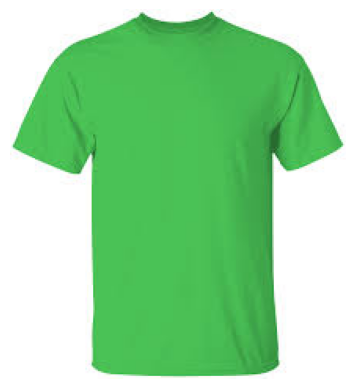

In [120]:
image_path = '/home/paperspace/src/styler/src/tmp_dir/green_shirt.png'
original_image = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

plt.imshow(original_image)
plt.axis('off')
plt.show()

In [3]:
import numpy as np
import webcolors

class MaskNClassifier:
  def __init__(self, sam_checkpoint, model_type, device, CLASSIFICATION_MODEL_NAME):


    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    self.mask_generator = SamAutomaticMaskGenerator(sam)

    self.processor = ViTImageProcessor.from_pretrained(CLASSIFICATION_MODEL_NAME)
    self.classifier = ViTForImageClassification.from_pretrained(CLASSIFICATION_MODEL_NAME)
    self.top_category = pd.read_csv("category_to_top_category.csv").set_index("Name")

  def get_masks(self, image):
    masks = self.mask_generator.generate(image)
    return masks

  def classify(self, image: np.ndarray) -> tuple:
    inputs = self.processor(images=image, return_tensors="pt")
    with torch.no_grad():
        logits = self.classifier(**inputs).logits

    logits = torch.softmax(logits, -1)
    confidence, idx = logits.max(-1)
    confidence, idx = confidence.item(), idx.item()
    label = self.classifier.config.id2label[idx]


    return label, confidence

  def _average_color(self, segmented_image):
    pixels = segmented_image.reshape(-1, 3).astype(float)

    non_black = pixels[np.any(pixels != [0, 0, 0], axis=1)]

    if len(non_black) > 0:
        return np.mean(non_black, axis=0).astype(int)
    else:
        return None



  def closest_colour(self, requested_colour):
      min_colours = {}
      for name in webcolors.names("css3"):
          r_c, g_c, b_c = webcolors.name_to_rgb(name)
          rd = (r_c - requested_colour[0]) ** 2
          gd = (g_c - requested_colour[1]) ** 2
          bd = (b_c - requested_colour[2]) ** 2
          min_colours[(rd + gd + bd)] = name
      return min_colours[min(min_colours.keys())]


  def _nearest_color(self, segmented_image, k=3):
    pixels = segmented_image.reshape(-1, 3)

    non_black = pixels[np.any(pixels != [0, 0, 0], axis=1)]

    if len(non_black) > 0:
        # Perform k-means clustering
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(non_black)

        # Get the colors
        colors = kmeans.cluster_centers_

        # Sort colors by their frequency
        labels = kmeans.labels_
        counts = np.bincount(labels)
        sorted_indices = np.argsort(counts)[::-1]

        return colors[sorted_indices].astype(int)[0]
    else:
        return None

  def get_dominant_color(self, segmented_image, type):
    if type == 'average':
      color = self._average_color(segmented_image)
    elif type == 'nearest':
      color = self._nearest_color(segmented_image)
    else:
      raise NotImplementedError

    if color is None:
      raise ValueError

    color_name = self.closest_colour(color)
    return color_name

  def get_metadata(self, image: np.ndarray, find_color='average'):
    masks = self.get_masks(image)

    metadata = {
        'bbox' : [],
        'label' : [],
        'condifence' : [],
        'color' : [],
        'top_category': [],
    }

    for mask in masks:
      x, y, w, h = mask['bbox']
      cropped_image = image[y:y+h, x:x+w].copy()
      if cropped_image.shape[0] < 2 or cropped_image.shape[1] < 2:
        continue
      cropped_image[~mask['segmentation'][y:y+h, x:x+w]] = 0.0
      label, confidence = self.classify(cropped_image)
      color = self.get_dominant_color(cropped_image, find_color)
      tc = self.top_category.loc[label].Category

      metadata['bbox'].append(mask['bbox'] )
      metadata['label'].append(label)
      metadata['condifence'].append(confidence)
      metadata['color'].append(color)
      metadata['top_category'].append(tc)


    return metadata



In [4]:
CLASSIFICATION_MODEL_NAME = 'jolual2747/vit-clothes-classification'
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

clf = MaskNClassifier(sam_checkpoint, model_type, device, CLASSIFICATION_MODEL_NAME)

/home/paperspace/.local/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [44]:
md = clf.get_metadata(original_image, find_color='average')

In [45]:
md_df = pd.DataFrame(md)

In [46]:
md_df

,bbox,label,condifence,color,top_category
0,"[0, 2, 799, 595]",FINE JEWELRY,0.811025,lightslategrey,Other
1,"[346, 113, 126, 326]",TROUSERS,0.156855,silver,Bottom
2,"[415, 438, 40, 48]",SKIRTS,0.210038,black,Top
3,"[272, 109, 255, 382]",PANTS,0.225790,darkgrey,Top
4,"[329, 438, 71, 47]",SKIRTS,0.250737,black,Top
5,"[318, 108, 28, 44]",DRESSES,0.272869,whitesmoke,Top
6,"[319, 150, 27, 57]",FINE JEWELRY,0.533584,rosybrown,Other
7,"[319, 109, 182, 329]",DRESSES,0.170852,silver,Top
8,"[330, 438, 125, 48]",DRESSES,0.449882,black,Top
9,"[360, 111, 102, 19]",DRESSES,0.327414,lightgrey,Top


In [22]:
idx = md_df.groupby("top_category")["condifence"].transform(max) == md_df['condifence']
md_df[idx]

/tmp/ipykernel_2166/564486198.py:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = md_df.groupby("top_category")["condifence"].transform(max) == md_df['condifence']


,bbox,label,condifence,color,top_category
1,"[0, 2, 799, 595]",FINE JEWELRY,0.811755,white,Other
7,"[370, 157, 53, 47]",DRESSES,0.703227,darkslateblue,Top


In [19]:
from os import listdir
from os.path import isfile, join
from tqdm import tqdm

In [35]:
def write_to_file(file_path, image_id,top_color,bottom_color,top_type,bottom_type):
    with open(file_path, "a") as file:
        file.write(f"{image_id},{top_color},{bottom_color},{top_type},{bottom_type}\n")

In [38]:
# Get all images names needed to be processed
mypath = "/home/paperspace/src/styler/src/data/train/images"
all_images = set([f for f in listdir(mypath) if isfile(join(mypath, f))])

# Get all processed images
current_files = pd.read_csv("/home/paperspace/src/styler/src/data/train/color_info/color_metrics.csv")
processed_images = set(current_files.image_id.values)
# Find set of images which are not processed yet
images_remaining = all_images - processed_images
# For each image generate info
for img_path in tqdm(images_remaining):
    try:
        image_path = f'/home/paperspace/src/styler/src/data/train/images/{img_path}'
        original_image = cv2.imread(image_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        
        md = clf.get_metadata(original_image, find_color='nearest')
        md_df = pd.DataFrame(md)
        idx = md_df.groupby("top_category")["condifence"].transform(max) == md_df['condifence']
        md_df = md_df[idx]
        top_dict = md_df.query("top_category == 'Top'").to_dict('records')[0]
        bottom_dict = md_df.query("top_category == 'Bottom'").to_dict('records')[0]
        image_id = img_path
        top_color = top_dict['color']
        bottom_color = bottom_dict['color']
        top_type = top_dict['label']
        bottom_type = bottom_dict['label']
        write_to_file("/home/paperspace/src/styler/src/data/train/color_info/color_metrics.csv",image_id,top_color,bottom_color,top_type,bottom_type)
    except Exception as e:
        print(e)
        print("Failed to run for ", img_path)
# Put info in csv

  0%|          | 0/1709 [00:00<?, ?it/s]/tmp/ipykernel_1827/4026062523.py:19: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = md_df.groupby("top_category")["condifence"].transform(max) == md_df['condifence']
  0%|          | 1/1709 [00:07<3:23:37,  7.15s/it]

                 bbox         label  condifence          color top_category
3   [0, 330, 415, 85]  FINE JEWELRY    0.944993          white        Other
6  [198, 104, 44, 75]       DRESSES    0.777957  darkslategrey          Top
list index out of range
Failed to run for  0401300_jpg.rf.24d46372e008bf9fc8f3a042e001e538.jpg


/tmp/ipykernel_1827/4026062523.py:19: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  idx = md_df.groupby("top_category")["condifence"].transform(max) == md_df['condifence']
  0%|          | 2/1709 [00:29<7:44:52, 16.34s/it]

                  bbox       label  condifence    color top_category
50    [0, 327, 70, 15]     SCARVES    0.778920  dimgrey        Other
53  [335, 256, 67, 13]     DRESSES    0.779695     grey          Top
83  [120, 159, 61, 68]  LOUNGEWEAR    0.136671    linen       Bottom


  0%|          | 2/1709 [00:39<9:18:18, 19.62s/it]


KeyboardInterrupt: 

In [33]:
md_df.query("top_category == 'Top'").to_dict('records')[0]

{'bbox': [120, 0, 160, 88],
 'label': 'DRESSES',
 'condifence': 0.8968275189399719,
 'color': 'grey',
 'top_category': 'Top'}

In [15]:
current_files.image_id.values

array([], dtype=object)

In [10]:
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(120, 90, 85)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[0]) + int(box[2]), int(box[1]) + int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)
    plt.imshow(image)

def plot_multiple_boxes(image, boxes):
  for i, box in enumerate(boxes):
    box_label(image, box, label = f"{i}")

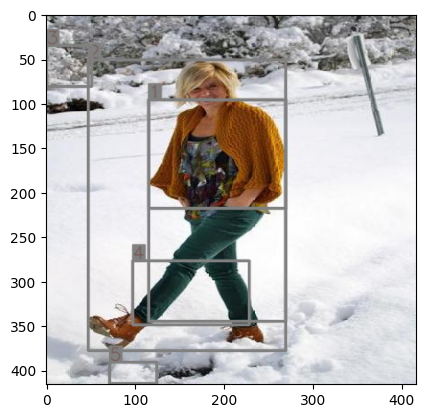

In [68]:
plot_multiple_boxes(original_image.copy(),
[[115, 96, 154, 122],
 [115, 96, 154, 249],
 [47, 51, 222, 327],
 [0, 35, 51, 46],
 [97, 277, 131, 72],
 [71, 391, 53, 24]])

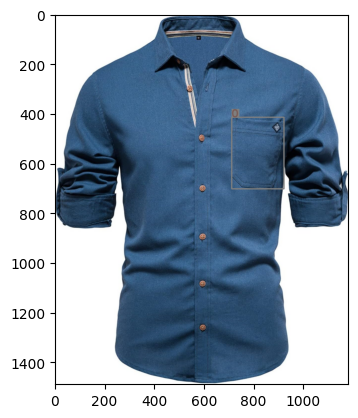

In [12]:
plot_multiple_boxes(original_image.copy(),
[[710, 415, 210, 288]])

In [71]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

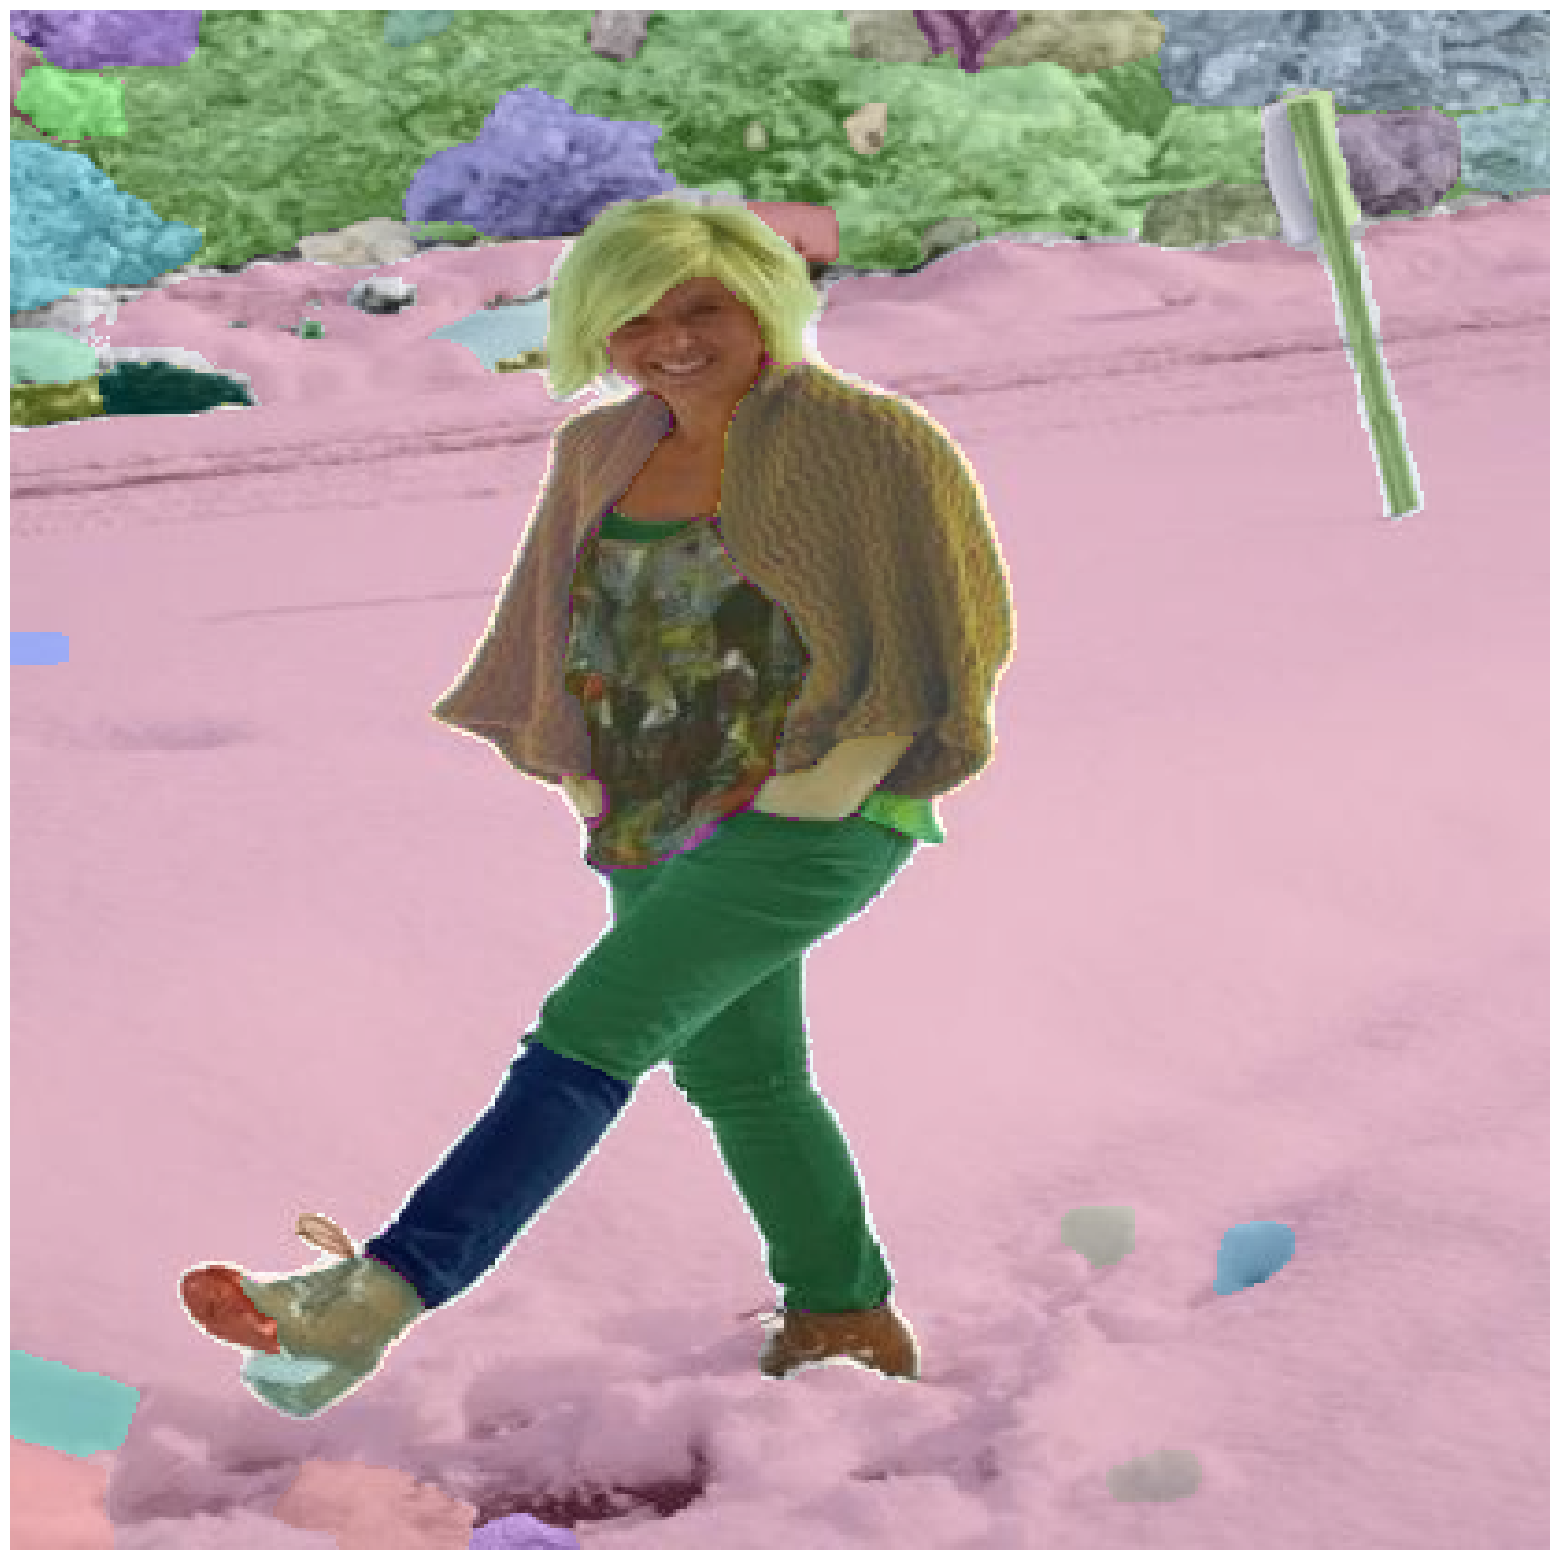

In [75]:
plt.figure(figsize=(20,20))
plt.imshow(original_image.copy())
show_anns(md)
plt.axis('off')
plt.show() 

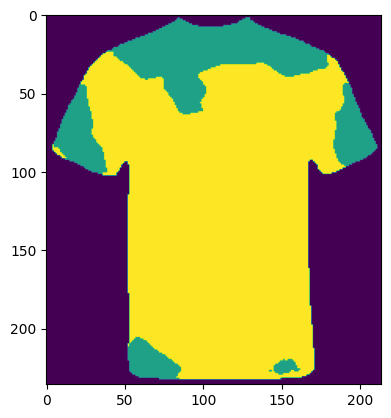

In [68]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn

processor = SegformerImageProcessor.from_pretrained("sayeed99/segformer_b3_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("sayeed99/segformer_b3_clothes")

url = "https://plus.unsplash.com/premium_photo-1673210886161-bfcc40f54d1f?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8cGVyc29uJTIwc3RhbmRpbmd8ZW58MHx8MHx8&w=1000&q=80"

image = Image.open("/home/paperspace/src/styler/src/tmp_dir/green_shirt.png")
inputs = processor(images=image, return_tensors="pt")

outputs = model(**inputs)
logits = outputs.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
plt.imshow(pred_seg)

In [98]:
upsampled_logits[0,7].mean()

tensor(5.5671, grad_fn=<MeanBackward0>)

In [122]:
t1 = upsampled_logits[0,7].detach().numpy()

In [123]:
t1[t1 < t1.mean()] = 0
t1[t1 >= t1.mean()] = 1

In [126]:
t2 = t1.reshape((t1.shape[0], t1.shape[1], 1))

In [127]:
original_image_copy = original_image * t2

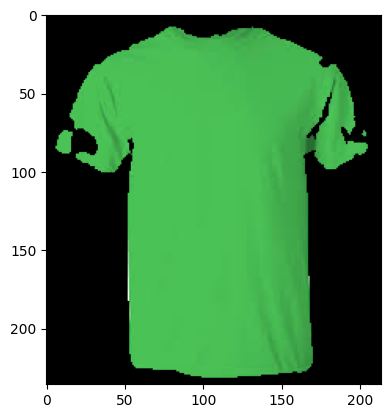

In [140]:
plt.imshow(original_image_copy.astype(int))